In [51]:
import pandas as pd
import os
import numpy as np

data_dir = 'storage/'
dataframes = {}

for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        print(f"Processing file: {filename}")
        asset_name = os.path.splitext(filename)[0]  # Remove .csv to get asset name
        file_path = os.path.join(data_dir, filename)
        
        # Read CSV and parse 'Date' column
        df = pd.read_csv(file_path, parse_dates=["Date"])
        
        # Store in dictionary using asset name
        dataframes[asset_name] = df
        print(f"Loaded {len(df)} rows for asset: {asset_name}")

Processing file: CBOE_VIX_15yr_data.csv
Loaded 3774 rows for asset: CBOE_VIX_15yr_data
Processing file: Crude_Oil_15yr_data.csv
Loaded 3773 rows for asset: Crude_Oil_15yr_data
Processing file: DXY_15yr_data.csv
Loaded 3775 rows for asset: DXY_15yr_data
Processing file: EUR_USD_15yr_data.csv
Loaded 3907 rows for asset: EUR_USD_15yr_data
Processing file: FTSE100_15yr_data.csv
Loaded 3787 rows for asset: FTSE100_15yr_data
Processing file: Gold_15yr_data.csv
Loaded 3772 rows for asset: Gold_15yr_data
Processing file: Nasdaq_15yr_data.csv
Loaded 3774 rows for asset: Nasdaq_15yr_data
Processing file: Nifty_50_15yr_data.csv
Loaded 3682 rows for asset: Nifty_50_15yr_data
Processing file: Nikkei_15yr_data.csv
Loaded 3670 rows for asset: Nikkei_15yr_data
Processing file: S&P500_15yr_data.csv
Loaded 3774 rows for asset: S&P500_15yr_data
Processing file: Silver_15yr_data.csv
Loaded 3772 rows for asset: Silver_15yr_data
Processing file: USD_INR_15yr_data.csv
Loaded 3907 rows for asset: USD_INR_15yr

In [52]:
df_gold = dataframes['Gold_15yr_data']
df_silver = dataframes['Silver_15yr_data']
df_crude_oil = dataframes['Crude_Oil_15yr_data']
df_usd_inr = dataframes['USD_INR_15yr_data']
df_dxy = dataframes['DXY_15yr_data']
df_nifty = dataframes['Nifty_50_15yr_data']
df_nasdaq = dataframes['Nasdaq_15yr_data']
df_ftse100 = dataframes['FTSE100_15yr_data']
df_nikkei = dataframes['Nikkei_15yr_data']
df_sp500 = dataframes['S&P500_15yr_data']
df_eur_usd = dataframes['EUR_USD_15yr_data']
df_vix = dataframes['CBOE_VIX_15yr_data']


assets = {
    'Gold': df_gold,
    'Silver': df_silver,
    'Crude_Oil': df_crude_oil,
    'USD_INR': df_usd_inr,
    # 'DXY': df_dxy,
    # 'EUR_USD': df_eur_usd,
    # 'S&P500': df_sp500,
    # 'Nasdaq': df_nasdaq,
    # 'Nikkei': df_nikkei,
    # 'FTSE100': df_ftse100,
    # 'CBOE_VIX': df_vix,
    'Nifty50': df_nifty
}


In [53]:
def engineer_features(df, prefix, rich_features=False):

    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')


    df = df.sort_values('Date').copy()
    df[f'{prefix}_return_1d'] = df['Close'].pct_change()
    df[f'{prefix}_return_3d'] = df['Close'].pct_change(3)
    if rich_features:
        df[f'{prefix}_vol_5d'] = df['Close'].pct_change().rolling(5).std()
        df[f'{prefix}_intraday_range'] = (df['High'] - df['Low']) / df['Open']
        df[f'{prefix}_volume_chg'] = df['Volume'].pct_change()
    return df[['Date'] + [col for col in df.columns if col.startswith(prefix)]]

In [54]:
base_df = engineer_features(assets['Nifty50'], 'nifty', rich_features=True)

from functools import reduce

merged_df = base_df.copy()


for asset, df in assets.items():
    if asset == 'Nifty50':
        continue  # Skip, already the base
    rich = asset in ['Gold', 'USD_INR', 'Crude_Oil']
    feat_df = engineer_features(df, asset, rich_features=rich)
    merged_df = merged_df.merge(feat_df, on='Date', how='left')


merged_df.fillna(method='ffill', inplace=True)  # Forward fill
nifty_close_df = assets['Nifty50'][['Date', 'Close']].copy()
nifty_close_df['Close'] = pd.to_numeric(nifty_close_df['Close'], errors='coerce')
nifty_close_df = nifty_close_df.sort_values('Date')
nifty_close_df['target'] = (nifty_close_df['Close'].shift(-1) > nifty_close_df['Close']).astype(int)


In [55]:
merged_df = merged_df.merge(nifty_close_df[['Date', 'target']], on='Date', how='left')
merged_df = merged_df.drop('USD_INR_volume_chg', axis=1)

merged_df.dropna(inplace=True)


In [56]:
final_df = merged_df.copy()

# Feature and target columns
features = [col for col in final_df.columns if col not in ['Date', 'target']]
X = final_df[features].values
y = final_df['target'].values

In [57]:
print(np.isinf(X).sum())
X_clean = np.where(np.isinf(X), np.nan, X)
print(np.isnan(X_clean).sum())

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')  # or strategy='mean'
X_imputed = imputer.fit_transform(X_clean)

55
55


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

IndexError: index 16 is out of bounds for axis 0 with size 16

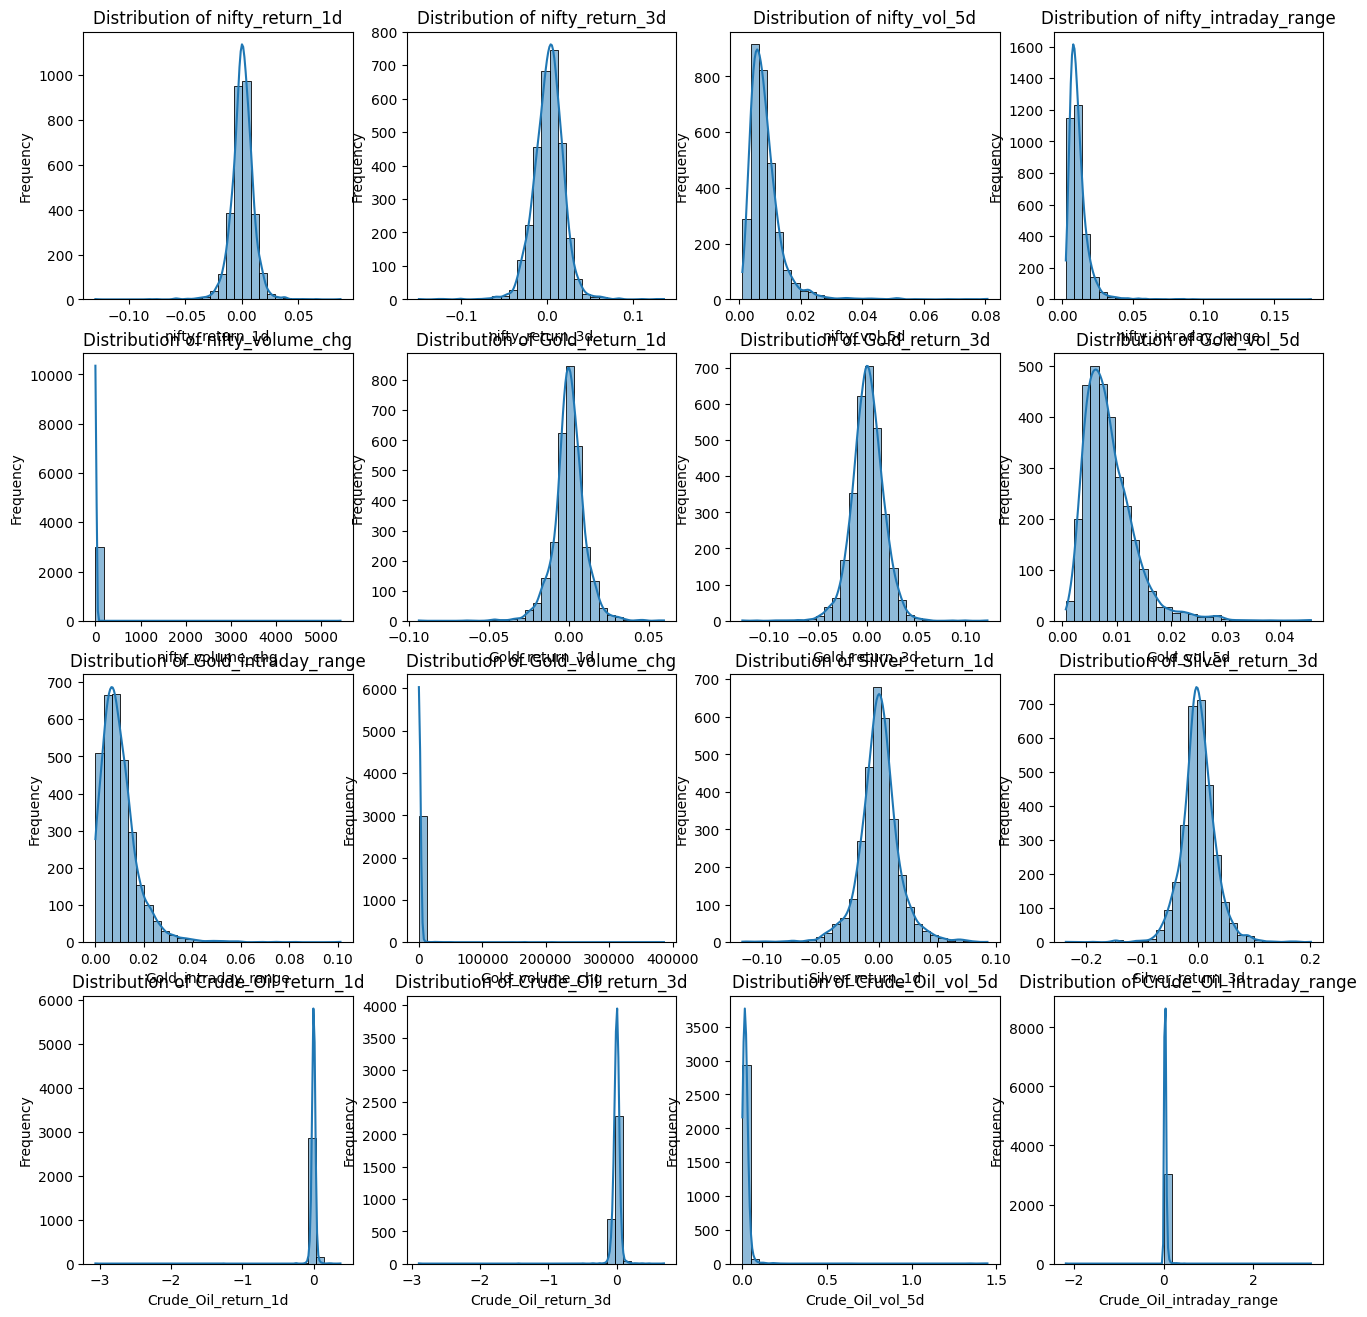

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'features' is a list of column names in 'final_df'
num_plots = len(features)

# Create a 4x4 grid (adjust the number of rows and columns as needed)
# In this case, we create enough subplots to handle up to 16 features
rows = 4
cols = 4

# Create a figure with the specified size (width x height)
fig, axes = plt.subplots(rows, cols, figsize=(16, 16))

# Flatten the axes array so we can iterate over it easily
axes = axes.flatten()

# Loop over each feature and plot its distribution
for i, col in enumerate(features):
    sns.histplot(final_df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots if the number of features is less than 16
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


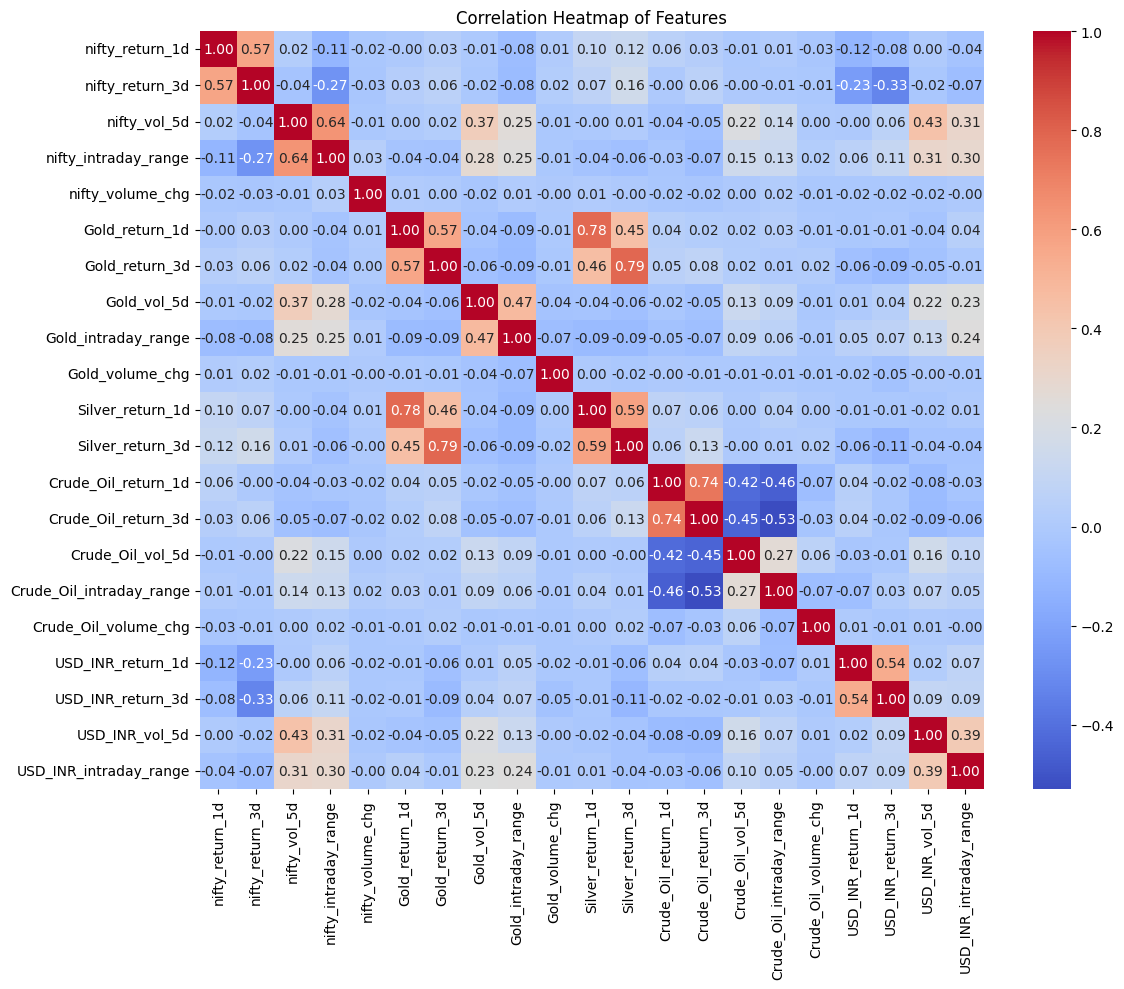

In [60]:
corr_matrix = final_df[features].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Features')
plt.tight_layout()
plt.show()

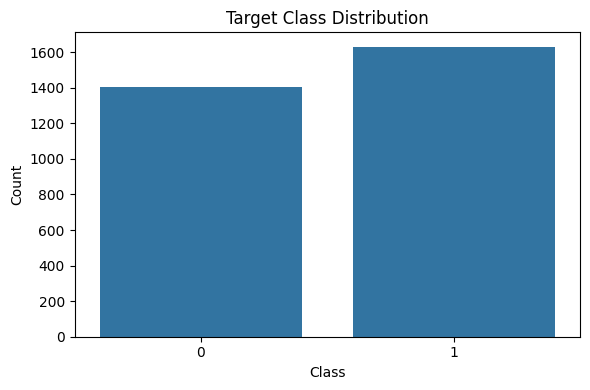

In [61]:
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=final_df)
plt.title('Target Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()